In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


**Load required libraries**

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import io

from scipy.stats import iqr

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

In [6]:
from google.colab import files
uploaded = files.upload()

Saving bank.csv to bank (4).csv


**Load the data**

In [0]:
df = pd.read_csv(io.BytesIO(uploaded['bank.csv']))

In [8]:
print('Data-set shape{}'.format(df.shape))

Data-set shape(10000, 14)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [10]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Check for null values**

In [11]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

**Drop features that may not be useful for analysis**

In [12]:
df.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)
df.sample(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7566,574,Spain,Male,36,4,77967.50,1,1,0,167066.95,1
8768,761,Germany,Male,62,5,98854.34,1,0,0,86920.97,1
4886,711,Germany,Female,53,5,123805.03,1,1,0,102428.51,0


**Univariate analysis**

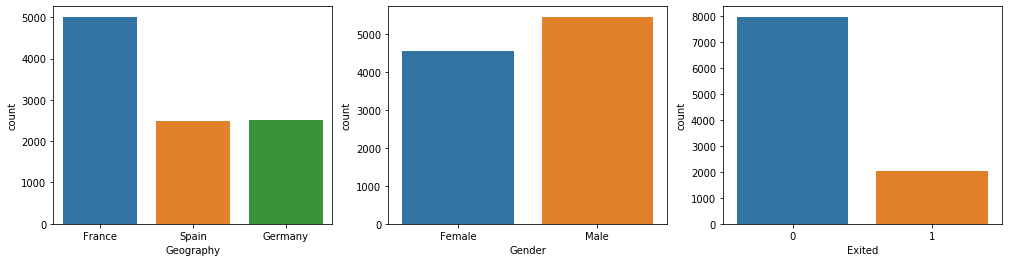

In [13]:
obj_col = df.select_dtypes(include=np.object).columns
obj_col

fig, ax = plt.subplots(1,3,figsize=(17,4))
i=0

for col in obj_col:
  sns.countplot(data=df, x=col, ax=ax[i] )
  i+=1
  
sns.countplot(data=df, x='Exited',ax=ax[i])
plt.show()

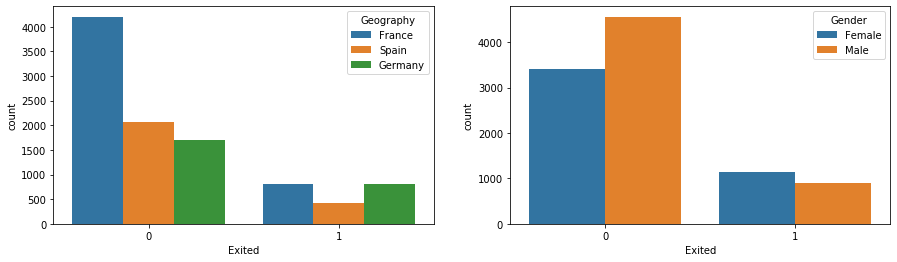

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
i=0

for col in obj_col:
  sns.countplot(data=df, x='Exited',hue=col, ax=ax[i])
  i+=1
  
plt.show()

In [15]:
# No of persons left and with bank, from each geography location w.r.t gender
df.pivot_table(index=['Exited','Geography'], columns='Gender',aggfunc='count')

Age       Balance        ... NumOfProducts       Tenure      
Gender           Female  Male  Female  Male  ...        Female  Male Female  Male
Exited Geography                             ...                                 
0      France      1801  2403    1801  2403  ...          1801  2403   1801  2403
       Germany      745   950     745   950  ...           745   950    745   950
       Spain        858  1206     858  1206  ...           858  1206    858  1206
1      France       460   350     460   350  ...           460   350    460   350
       Germany      448   366     448   366  ...           448   366    448   366
       Spain        231   182     231   182  ...           231   182    231   182

[6 rows x 16 columns]

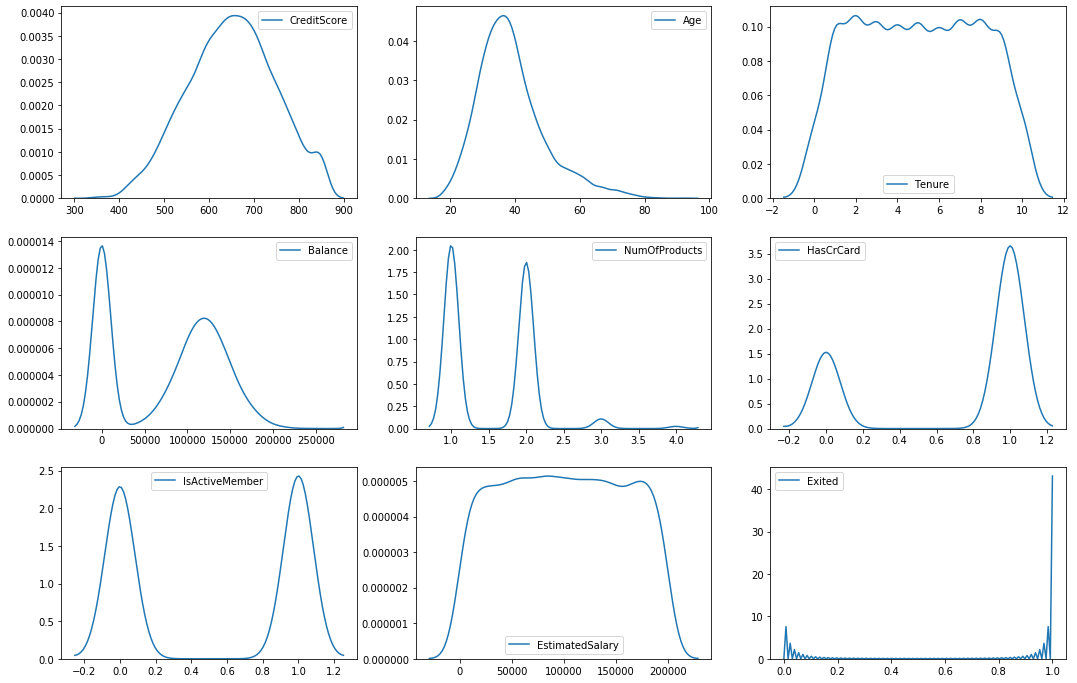

In [16]:
non_obj_col = df.select_dtypes(exclude=np.object).columns

fig, ax = plt.subplots(3,3,figsize=(18,12))
i=0
j=0

for col in non_obj_col:
  sns.kdeplot(df[col],ax=ax[i,j])
  j+=1 

  if( 0  == (j%3) ):
    i+=1
    j=0


In [17]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


1. From the above it could be infered in most of the features 2 modes are visible.
2. Except Feature 'Tenure' most of others features are skewed 

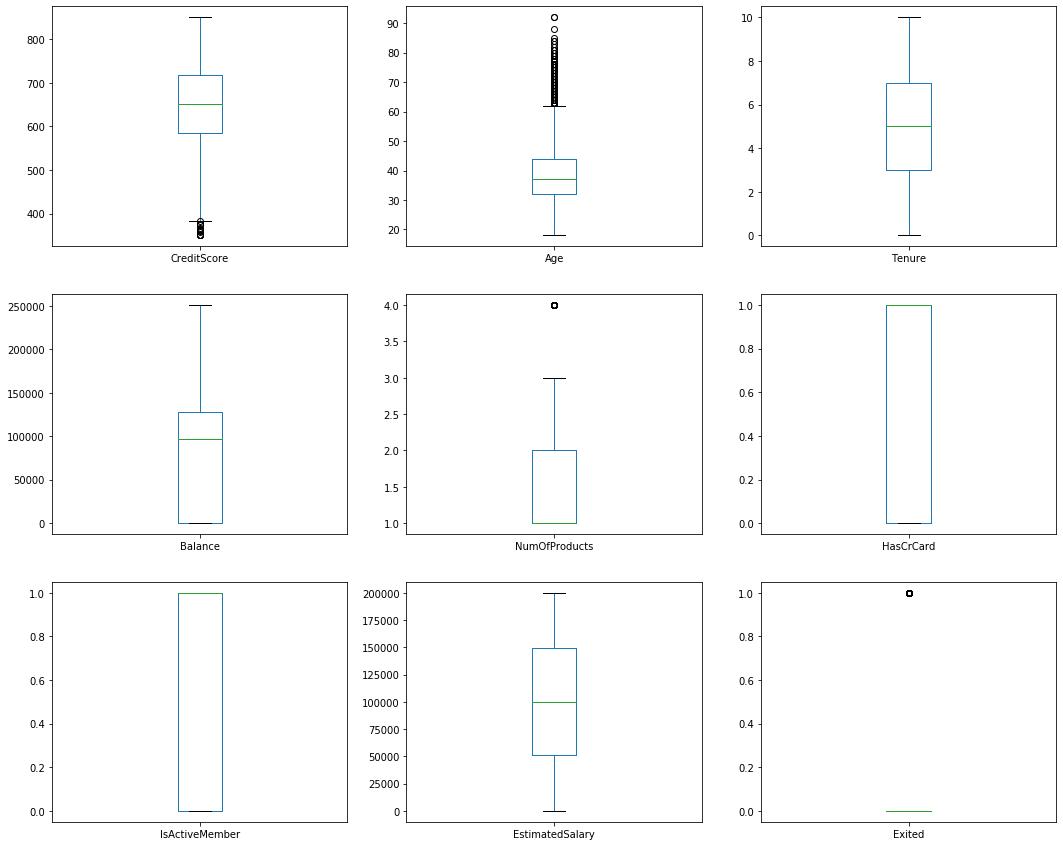

In [18]:
non_obj_col = df.select_dtypes(exclude=np.object).columns

fig, ax = plt.subplots(3,3,figsize=(18,15))
i=0
j=0

for col in non_obj_col:
  df[col].plot.box(ax=ax[i,j])
  #sns.boxplot(df[col],ax=ax[i,j])
  j+=1 

  if( 0  == (j%3) ):
    i+=1
    j=0

plt.show()

In [19]:
IQR = iqr(df.drop(columns=['Gender','Geography']),axis=0)
q1,q3 = np.percentile(df.drop(columns=['Gender','Geography']),[25,75],axis=0)
lower_bound = q1 - (1.5 * IQR)
upper_bound = q3 + (1.5 * IQR)
lower_bound_count = (df.drop(columns=['Gender','Geography']) < lower_bound).sum()
upper_bound_count = (df.drop(columns=['Gender','Geography']) > upper_bound).sum()

d = { 'Q1':q1,'Q3':q3,'IQR':IQR,'lower_bound_values':lower_bound,'upper_bound_values':upper_bound,\
         'lower_bound_counts':lower_bound_count, 'upper_bound_counts': upper_bound_count}

outlier_df = pd.DataFrame(data= d, index=non_obj_col)
outlier_df

,Q1,Q3,IQR,lower_bound_values,upper_bound_values,lower_bound_counts,upper_bound_counts
CreditScore,584.00,718.0000,134.0000,383.00000,919.00000,15,0
Age,32.00,44.0000,12.0000,14.00000,62.00000,0,359
Tenure,3.00,7.0000,4.0000,-3.00000,13.00000,0,0
Balance,0.00,127644.2400,127644.2400,-191466.36000,319110.60000,0,0
NumOfProducts,1.00,2.0000,1.0000,-0.50000,3.50000,0,60
HasCrCard,0.00,1.0000,1.0000,-1.50000,2.50000,0,0
IsActiveMember,0.00,1.0000,1.0000,-1.50000,2.50000,0,0
EstimatedSalary,51002.11,149388.2475,98386.1375,-96577.09625,296967.45375,0,0
Exited,0.00,0.0000,0.0000,0.00000,0.00000,0,2037


1. Feature 'Numberofproducts', 'Age' & 'CreditScore' are having outliers.
2. Here, outliers are not handled.

In [20]:
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


**Handle categorical variable**

In [21]:
df = pd.get_dummies(df,columns=['Geography','Gender'], drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


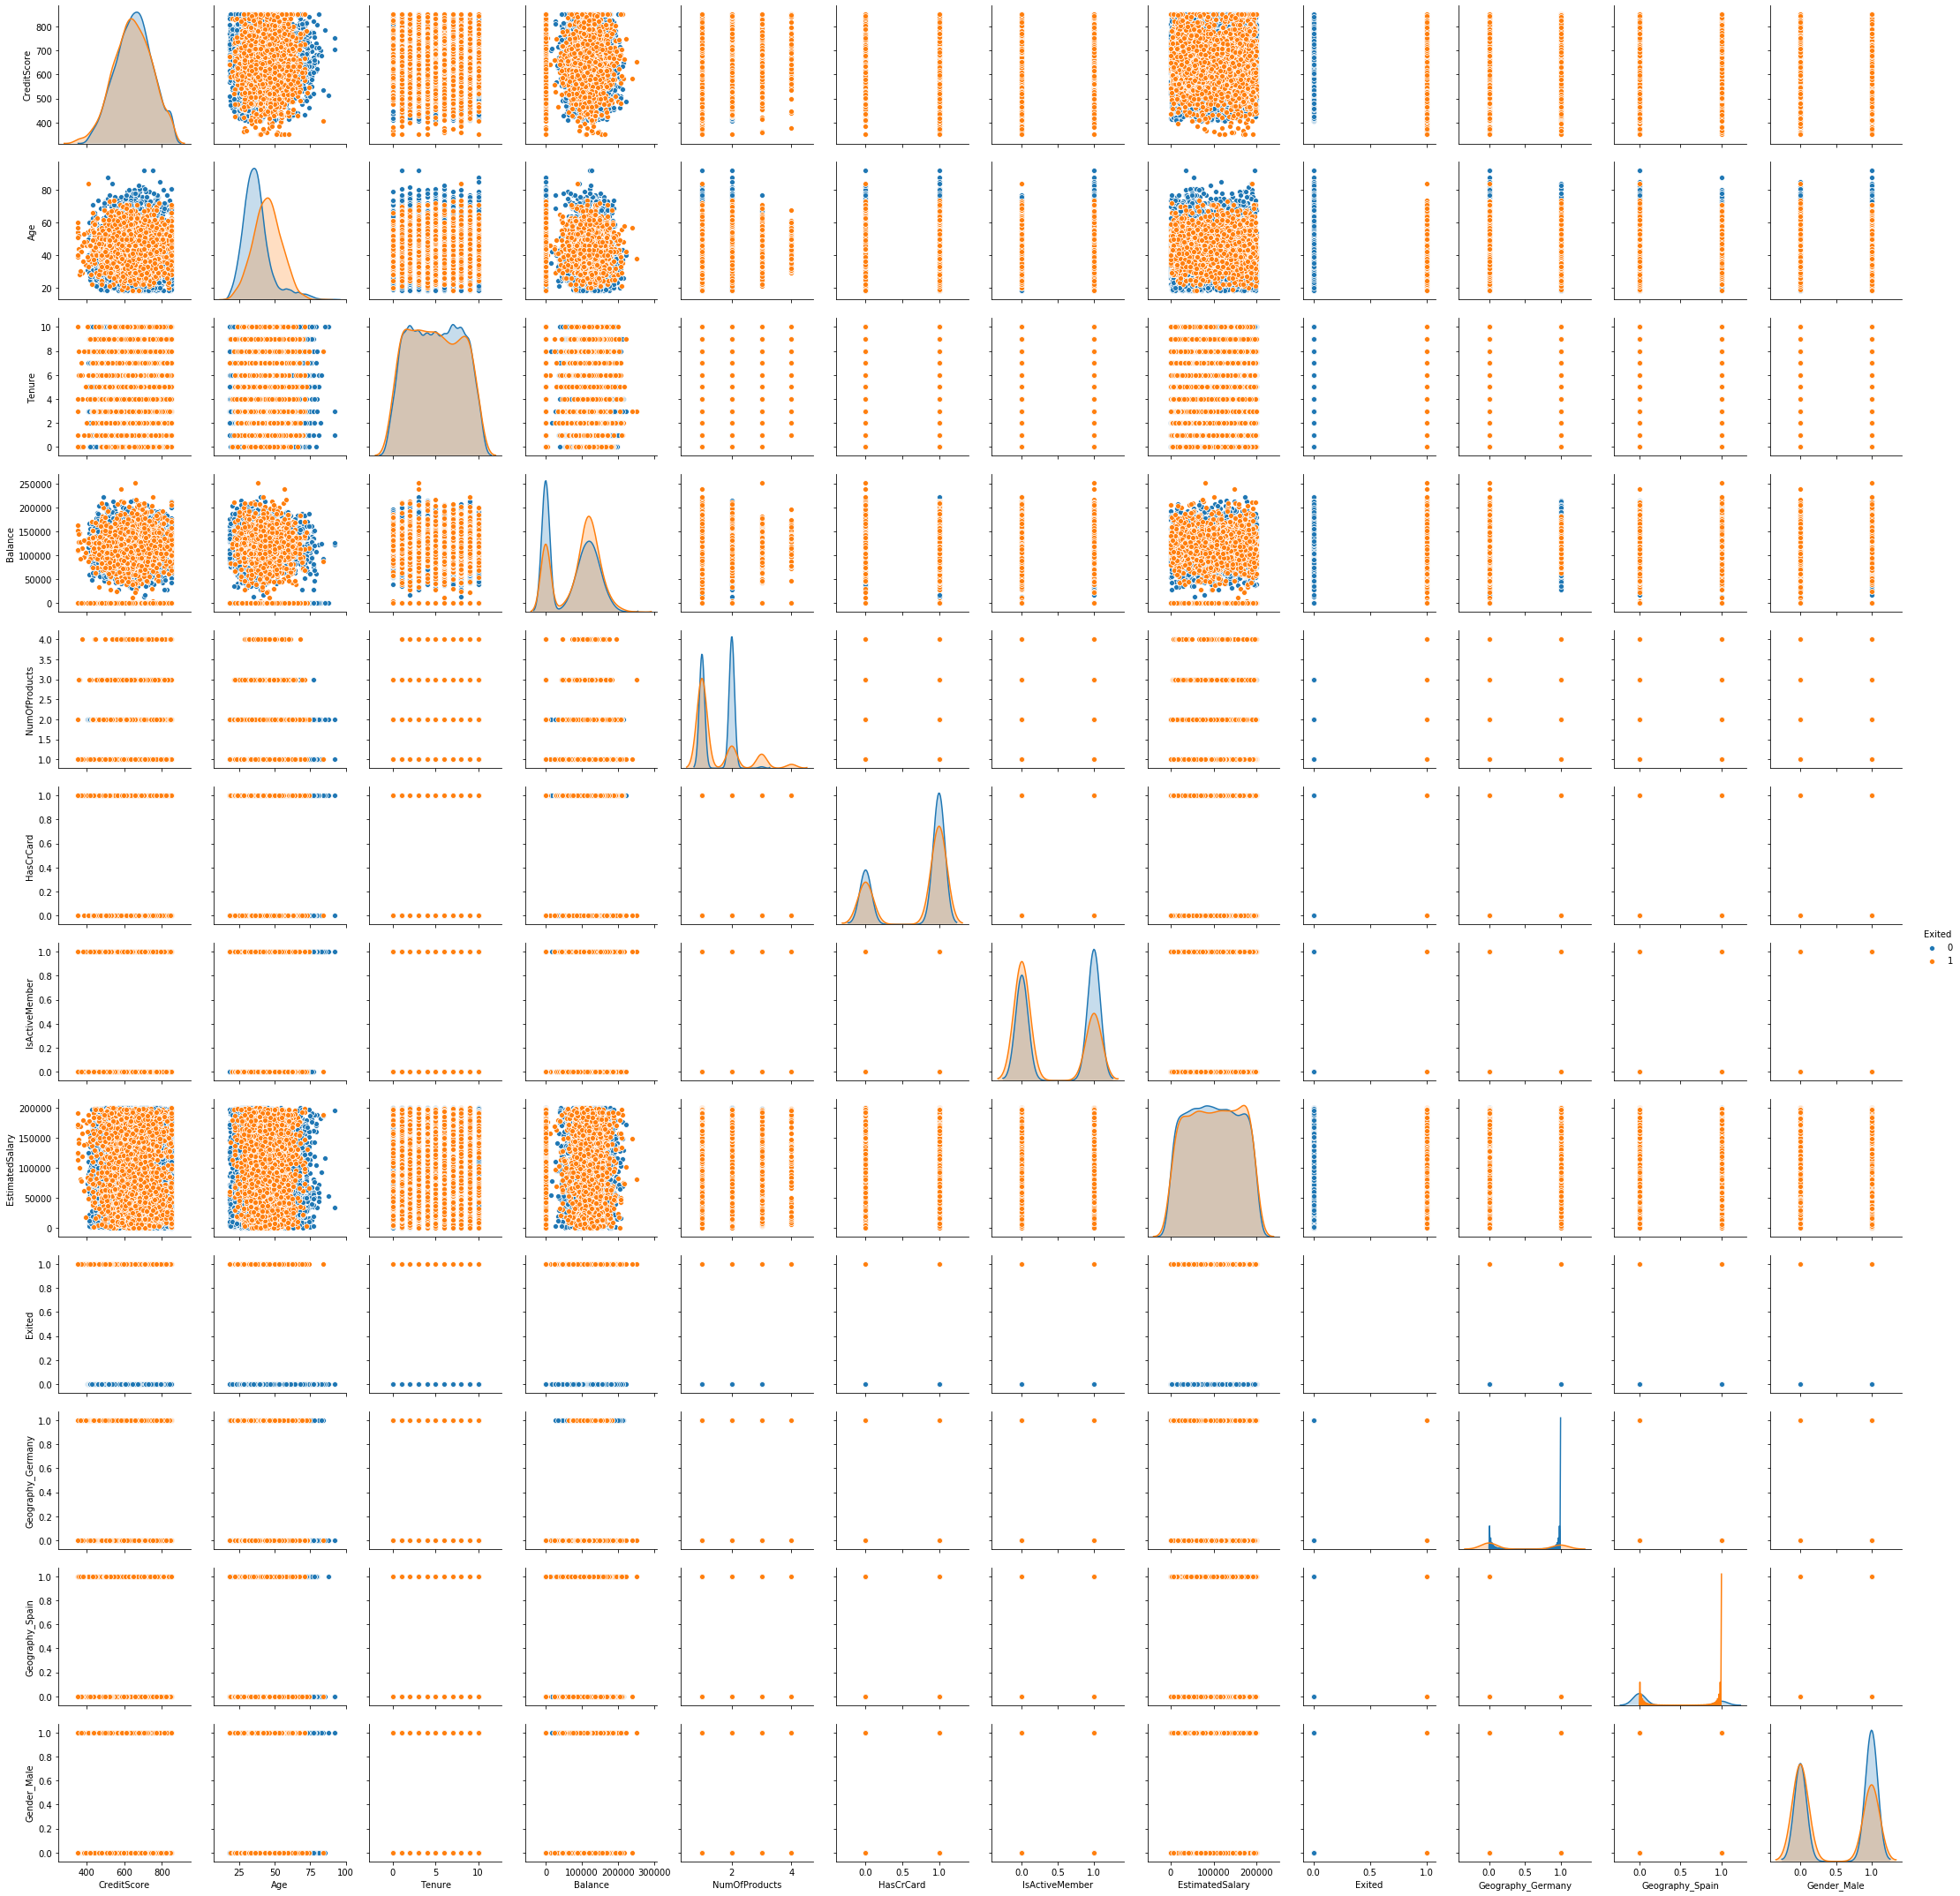

In [22]:
sns.pairplot(df,diag_kind='kde',hue='Exited')
plt.show()

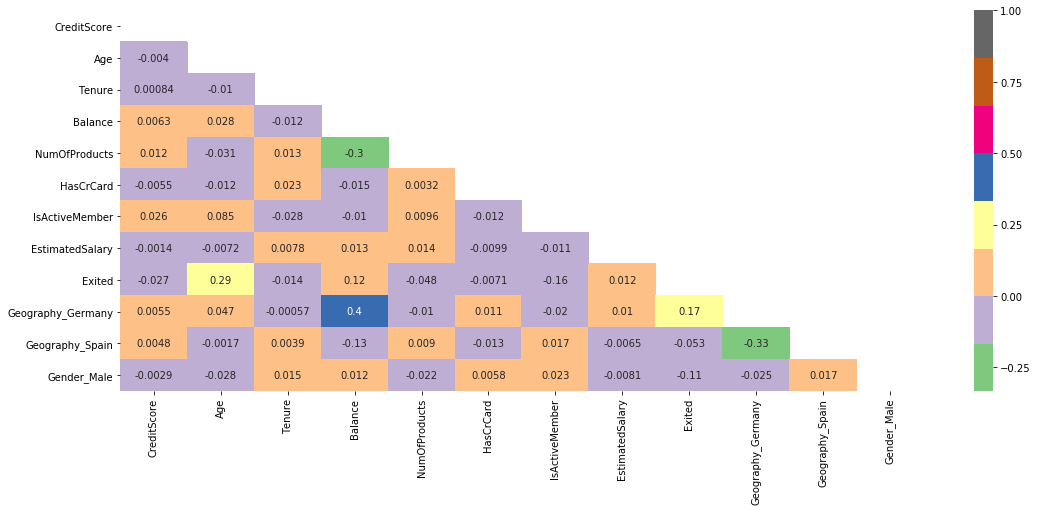

In [23]:
fig, ax = plt.subplots(1,1, figsize=(18,7))

corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap='Accent', ax=ax)

plt.show()

1. It could be infered that most of the features are having less or no correclation at all (i.e co-variance < +/-0.2)
2. For the given example, feature 'Geography_German' vs 'Balance' & 'Exited' Vs 'Age'are having better +ve correlation
3. 'Numberofproducts' vs 'Balance' has -ve correlations

In [24]:
#Derive the predictors and target variables
X = df.drop(columns=['Exited'])
y = df['Exited']

# Split the data-set into train and test (of 80:20 ratio)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.30, random_state=3)
print('Train data-set size: X_train{} y_train{}'.format(x_train.shape,y_train.shape))
print('Test data-set size: X_test{} y_test{}'.format(x_test.shape,y_test.shape))

Train data-set size: X_train(7000, 11) y_train(7000,)
Test data-set size: X_test(3000, 11) y_test(3000,)


In [0]:
# normalise / scale as the features are in different units
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)


**Build the Neural Network architecture**


Model - test loss: 35.85373718738556
Model - test accuracy: 85.9666645526886


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                192       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 273
Trainable params: 241
Non-trainable params: 32
_________________________________________________________________


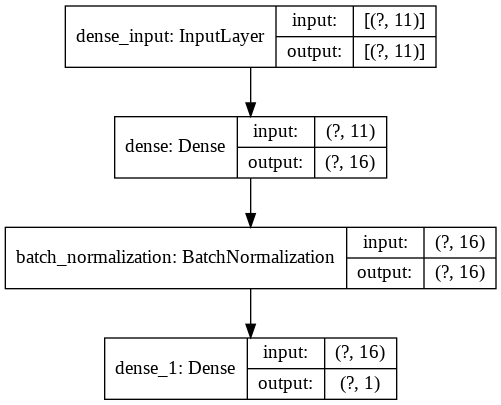

In [26]:
# Initialize Sequential model
model = tf.keras.models.Sequential()

# Add Dense Layer 
model.add(tf.keras.layers.Dense(16,activation='relu', input_dim=x_train.shape[1]))

# Normalize the data
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Compile the model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
m_1h_relu = model.fit(x_train, y_train, validation_split=0.20, epochs=50, verbose=0 )

### Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Model - test loss:", test_loss * 100)
print("Model - test accuracy:", test_acc * 100)
print('\n')

model.summary()

tf.keras.utils.plot_model(model,show_shapes=True)


Understand the behavior for the model with 1 Hidden layer
where output layer activation function is sigmoid and hidden layer activation is tried with various activatoin fucntion. Loss function is binary_entropy

In [0]:
def Build_Seq_model_1HL(HL_activation_fn):
  
  # Initialize Sequential model
  model = tf.keras.models.Sequential()

  # Add Dense Layer 
  model.add(tf.keras.layers.Dense(16,activation=HL_activation_fn, input_dim=x_train.shape[1]))
  
  # Normalize the data
  model.add(tf.keras.layers.BatchNormalization())
  
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  ### Compile the model
  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # Train the model
  m_1h_his = model.fit(x_train, y_train, validation_split=0.20, epochs=50, verbose=0 )

  ### Evaluate the model
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  print("Model - test loss:", test_loss * 100)
  print("Model - test accuracy:", test_acc * 100)
  print('\n')

  model.summary()

  return m_1h_his

In [28]:
m_1h_tanh = Build_Seq_model_1HL('tanh')

Model - test loss: 34.92152585983276
Model - test accuracy: 86.36666536331177


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                192       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 273
Trainable params: 241
Non-trainable params: 32
_________________________________________________________________


In [29]:
m_1h_elu = Build_Seq_model_1HL('elu')

Model - test loss: 35.39798836708069
Model - test accuracy: 85.9333336353302


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                192       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 273
Trainable params: 241
Non-trainable params: 32
_________________________________________________________________


In [30]:
m_1h_selu = Build_Seq_model_1HL('selu')

Model - test loss: 35.338355835278826
Model - test accuracy: 86.00000143051147


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                192       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 273
Trainable params: 241
Non-trainable params: 32
_________________________________________________________________


In [31]:
m_1h_exp = Build_Seq_model_1HL('exponential')

Model - test loss: 36.23975641727448
Model - test accuracy: 86.00000143051147


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                192       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 273
Trainable params: 241
Non-trainable params: 32
_________________________________________________________________


In [32]:
m_1h_lin = Build_Seq_model_1HL('linear')

Model - test loss: 44.04311202367147
Model - test accuracy: 80.83333373069763


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                192       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 273
Trainable params: 241
Non-trainable params: 32
_________________________________________________________________


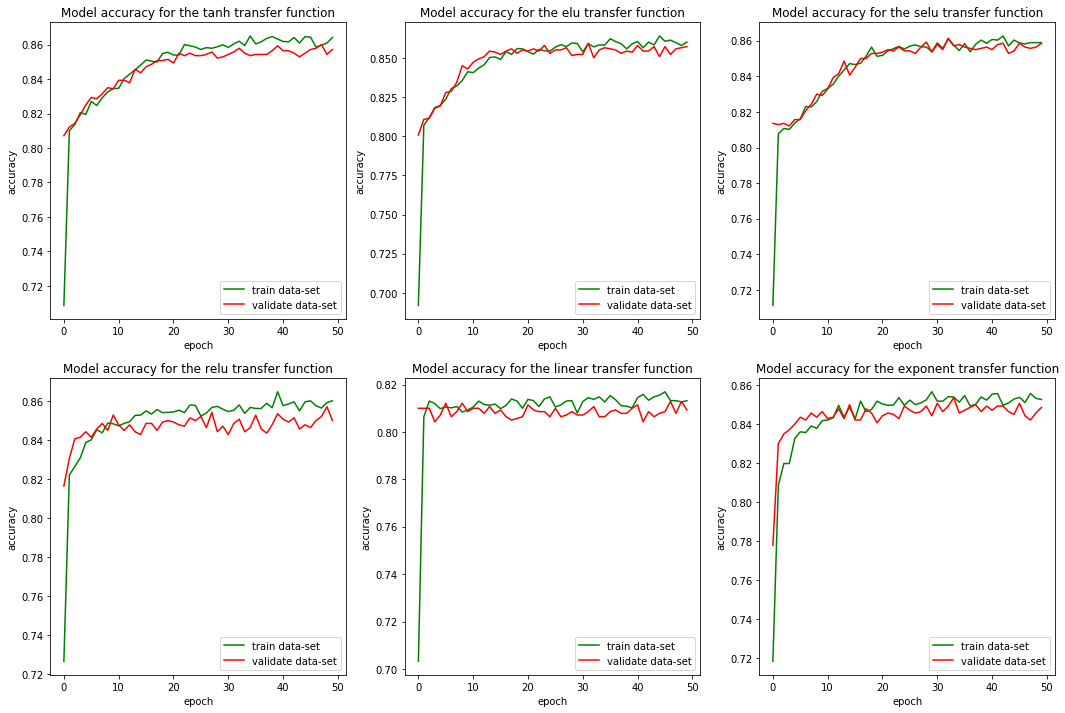

In [33]:
def plot_model_history(ax, history, train_metric, val_metric, actv_func ):
  ax.plot(history[train_metric], 'green',label='train data-set')
  ax.plot(history[val_metric], 'red',label='validate data-set')
  ax.set_title('Model {} for the {} transfer function'.format(train_metric,actv_func))
  ax.set_ylabel(train_metric)
  ax.set_xlabel('epoch')
  ax.legend()

fig, ax = plt.subplots(2, 3, figsize=(18,12))
plot_model_history(ax[0,0], m_1h_tanh.history, 'accuracy', 'val_accuracy', 'tanh')
plot_model_history(ax[0,1], m_1h_elu.history, 'accuracy', 'val_accuracy', 'elu')
plot_model_history(ax[0,2], m_1h_selu.history, 'accuracy', 'val_accuracy', 'selu')
plot_model_history(ax[1,0], m_1h_relu.history, 'accuracy', 'val_accuracy', 'relu')
plot_model_history(ax[1,1], m_1h_lin.history, 'accuracy', 'val_accuracy', 'linear')
plot_model_history(ax[1,2], m_1h_exp.history, 'accuracy', 'val_accuracy', 'exponent')


plt.show()

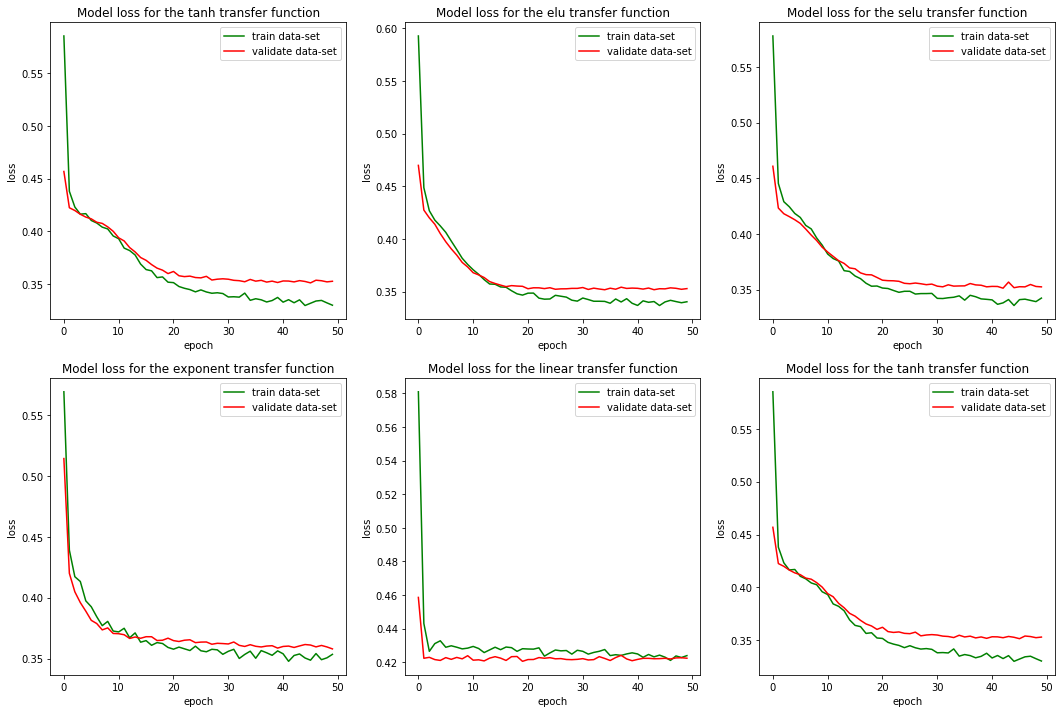

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(18,12))
plot_model_history(ax[0,0], m_1h_tanh.history, 'loss', 'val_loss', 'tanh')
plot_model_history(ax[0,1], m_1h_elu.history, 'loss', 'val_loss', 'elu')
plot_model_history(ax[0,2], m_1h_selu.history, 'loss', 'val_loss', 'selu')
plot_model_history(ax[1,0], m_1h_exp.history, 'loss', 'val_loss', 'exponent')
plot_model_history(ax[1,1], m_1h_lin.history, 'loss', 'val_loss', 'linear')
plot_model_history(ax[1,2], m_1h_tanh.history, 'loss', 'val_loss', 'tanh')

plt.show()

**GridsearchCV for Neural network models**

In [0]:
def SVC_GridSearchValidation(estimator, param_grid):
  
    svcgscv = GridSearchCV(estimator, param_grid=param_grid, cv=3)
    svcgscv.fit(x_train,y_train)
        
    print('\nGridSearch Parameter setting that gave the best results on the hold out data\n\t', svcgscv.best_params_)
    print('\nMean cross-validated score of the best_estimator\n\t',svcgscv.best_score_)
    
    print('\nTest score{}\n\t'.format(svcgscv.score(x_test,y_test)))

In [0]:
# Here optimiser is RMSprop
def create_NN_model(activation, loss, learning_rate):
  # create model
  model = tf.keras.models.Sequential()
  
  model.add(tf.keras.layers.Dense(16, input_dim=x_train.shape[1], activation=activation))
  
  # Normalize the data
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))
  
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

  # Compile model
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

In [0]:
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)

In [0]:
model_nn = KerasClassifier(build_fn=create_NN_model, activation='selu', loss = 'binary_crossentropy', learning_rate=0.01, epochs=50, verbose=0 )

In [40]:
SVC_GridSearchValidation(estimator=model_nn, param_grid=param_grid)


GridSearch Parameter setting that gave the best results on the hold out data
	 {'learning_rate': 0.01}

Mean cross-validated score of the best_estimator
	 0.8568571515338761

Test score0.8560000061988831
	


In [41]:
model_nn = KerasClassifier(build_fn=create_NN_model, activation='tanh', loss = 'binary_crossentropy', learning_rate=0.01, epochs=50, verbose=0 )
SVC_GridSearchValidation(estimator=model_nn, param_grid=param_grid)


GridSearch Parameter setting that gave the best results on the hold out data
	 {'learning_rate': 0.001}

Mean cross-validated score of the best_estimator
	 0.8532857100963592

Test score0.8586666584014893
	


In [0]:
# Here optimiser is SGD
def create_NN_model(activation, loss, learning_rate):
  # create model
  model = tf.keras.models.Sequential()
  
  model.add(tf.keras.layers.Dense(16, input_dim=x_train.shape[1], activation=activation))
  
  # Normalize the data
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))
  
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Compile model
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

In [43]:
model_nn = KerasClassifier(build_fn=create_NN_model, activation='tanh', loss = 'binary_crossentropy', learning_rate=0.01, epochs=50, verbose=0 )
SVC_GridSearchValidation(estimator=model_nn, param_grid=param_grid)


GridSearch Parameter setting that gave the best results on the hold out data
	 {'learning_rate': 0.1}

Mean cross-validated score of the best_estimator
	 0.857714283474854

Test score0.8533333539962769
	


Model - test loss: 34.74086218674978
Model - test accuracy: 86.2666666507721


confusion matrix
 [[2282   99]
 [ 313  306]]
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 16)                192       
_________________________________________________________________
batch_normalization_66 (Batc (None, 16)                64        
_________________________________________________________________
dense_127 (Dense)            (None, 32)                544       
_________________________________________________________________
batch_normalization_67 (Batc (None, 32)                128       
_________________________________________________________________
dense_128 (Dense)            (None, 1)                 33        
Total params: 961
Trainable params: 865
Non-trainable params: 96
______________________________________________________________

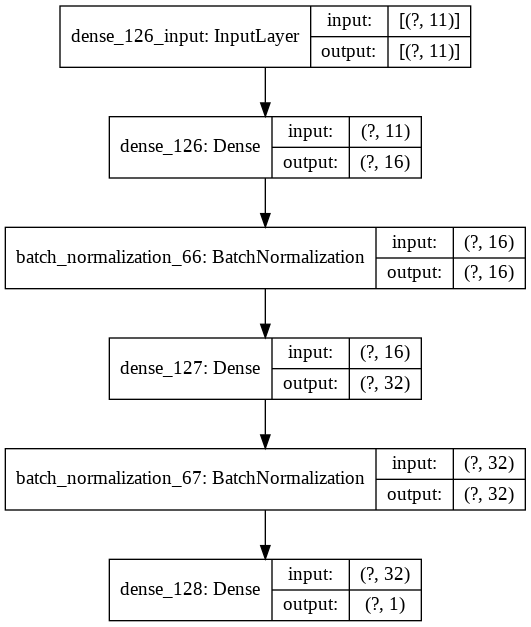

In [50]:
# Initialize Sequential model
model2 = tf.keras.models.Sequential()

# Add Dense Layer 
model2.add(tf.keras.layers.Dense(16,activation='elu', input_dim=x_train.shape[1]))

# Normalize the data
model2.add(tf.keras.layers.BatchNormalization())

model2.add(tf.keras.layers.Dense(32,activation='elu'))

# Normalize the data
model2.add(tf.keras.layers.BatchNormalization())

model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Compile the model
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model2.fit(x_train, y_train, validation_split=0.20, epochs=50, verbose=0 )

# Evalue the model
test_loss, test_acc = model2.evaluate(x_test, y_test, verbose=0)
print("Model - test loss:", test_loss * 100)
print("Model - test accuracy:", test_acc * 100)
print('\n')

m2_y_pred = model2.predict(x_test)
m2_y_pred = (m2_y_pred > 0.5).astype(int)

print('confusion matrix\n', confusion_matrix(y_test,m2_y_pred))

model2.summary()

tf.keras.utils.plot_model(model2,show_shapes=True)

Model - test loss: 35.74626133441925
Model - test accuracy: 85.69999933242798


confusion matrix
 [[2273  108]
 [ 321  298]]
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 16)                192       
_________________________________________________________________
batch_normalization_68 (Batc (None, 16)                64        
_________________________________________________________________
dense_130 (Dense)            (None, 32)                544       
_________________________________________________________________
batch_normalization_69 (Batc (None, 32)                128       
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 33        
Total params: 961
Trainable params: 865
Non-trainable params: 96
_____________________________________________________________

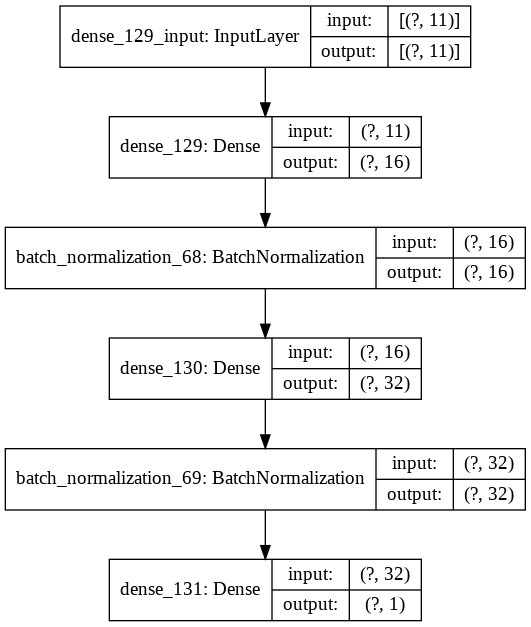

In [51]:
# Initialize Sequential model
model3 = tf.keras.models.Sequential()

# Add Dense Layer 
model3.add(tf.keras.layers.Dense(16,activation='tanh', input_dim=x_train.shape[1]))

# Normalize the data
model3.add(tf.keras.layers.BatchNormalization())

model3.add(tf.keras.layers.Dense(32,activation='tanh'))

# Normalize the data
model3.add(tf.keras.layers.BatchNormalization())

model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Compile the model
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model3.fit(x_train, y_train, validation_split=0.20, epochs=50, verbose=0 )

# Evalue the model
test_loss, test_acc = model3.evaluate(x_test, y_test, verbose=0)
print("Model - test loss:", test_loss * 100)
print("Model - test accuracy:", test_acc * 100)
print('\n')

m3_y_pred = model3.predict(x_test)
m3_y_pred = (m3_y_pred > 0.5).astype(int)

print('confusion matrix\n', confusion_matrix(y_test,m3_y_pred))

model3.summary()

tf.keras.utils.plot_model(model3,show_shapes=True)

**Observation**
1. It could be infered that model with tanh activation for hidden layer has better performance while compared to other activation function.
2. From GridsearchCV for the single HL, the better learning rate for RMSprop is learnt to be 0.01, for other loss functions the accuracy degrades.
3. As this example is binary classifcation, for output layer sigmoid activation function is used.
4. Adding more layer doesn't increase the performance at times it get decreases.
5. If we refer the model scrore so far ~85-87% is achived.
6. As in this example outliers was not handled, may be handling it may increase the perofrmance(to be verified).
